# RAG with Recursive Abstractive Processing for Tree-Organized Retrival (RAPTOR)

## Load Env variables

In [3]:
import os
from dotenv import load_dotenv

load_dotenv('app/src/shared/.env')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

In [4]:
import sklearn
print(sklearn.show_versions())


System:
    python: 3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:54:21) [Clang 16.0.6 ]
executable: /opt/homebrew/anaconda3/envs/tcc/bin/python
   machine: macOS-14.2.1-arm64-arm-64bit

Python dependencies:
      sklearn: 1.5.0
          pip: 23.3.1
   setuptools: 70.1.0
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: None
       pandas: 2.2.1
   matplotlib: 3.9.0
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /opt/homebrew/anaconda3/envs/tcc/lib/python3.12/site-packages/numpy/.dylibs/libopenblas64_.0.dylib
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: armv8

       user_api: blas
   internal_api: openblas
    num_threads: 8
         prefix: libopenblas
       filepath: /opt/homebrew/anaconda3/envs/tcc/lib/libopenblasp-r0.3.21.dylib
        version: 0.3.21
threading_layer: pthreads
   

## Define the LLM model and embedding parameters

In [14]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_openai import OpenAIEmbeddings

# embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001",
#                                     task_type="retrieval_document") # type: ignore


embd = OpenAIEmbeddings(model="text-embedding-3-large")

model = GoogleGenerativeAI(model="gemini-1.5-pro", temperature=0) # type: ignore

## Document loaders - Load Sources

### Loading the pdf docs with PyPDF loader

In [6]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from typing import List, Dict
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from typing import List


# Configure logging 
logging.basicConfig(filename='pdf_processing.log', level=logging.INFO, format='%(asctime)s %(message)s')

# Função de carregamento de PDF
def load_pdf_file(pdf_folder_path: str, filename: str) -> List[Document]:
    """Processes a single PDF file and returns the extracted elements.

    Logs information and errors during processing.
    """
    try:
        pages = []
        loader = PyPDFLoader(os.path.join(pdf_folder_path, filename))
        pages = loader.load()
        logging.info(f"Successfully processed PDF: {filename}")
        return pages
    except Exception as e:  # Catch specific PDF processing errors
        logging.error(f"Error processing PDF: {filename} - {e}")
        return []
    
    # Função para processar múltiplos PDFs
def process_multiple_pdfs(pdf_folder_path: str, max_workers: int = 8) -> Dict[str, List]:
    """Processes all PDF files within a specified folder using ThreadPoolExecutor.

    Logs information and errors during processing.
    """
    all_elements = {}
    filenames = [filename for filename in os.listdir(pdf_folder_path) if filename.endswith(".pdf")]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Mapeando cada filename para a função load_pdf_file com a pasta de PDFs
        future_to_filename = {executor.submit(load_pdf_file, pdf_folder_path, filename): filename for filename in filenames}

        for future in future_to_filename:
            filename = future_to_filename[future]
            try:
                result = future.result()
                all_elements[filename] = result  # Armazenando o resultado no dicionário
            except Exception as e:
                logging.error(f"Error processing PDF: {filename} - {e}")
                all_elements[filename] = []

    return all_elements


pdf_folder_path = "app/src/database/pdf"
pdf_results = process_multiple_pdfs(pdf_folder_path)

for filename, elements in pdf_results.items():
    print(f"PDF: {filename}, Pages: {len(elements)}")

PDF: NBR_5419_1.pdf, Pages: 77
PDF: NBR_5419_3.pdf, Pages: 61
PDF: ABNT_NBR_IEC_60079_14.pdf, Pages: 94
PDF: NBR_5419_2.pdf, Pages: 116
PDF: NBR_5410.pdf, Pages: 217
PDF: NBR_5413.pdf, Pages: 13
PDF: NBR_5419_4.pdf, Pages: 99
PDF: NBR_14039.pdf, Pages: 102
PDF: NBR_13570.pdf, Pages: 5
PDF: NBR_10898.pdf, Pages: 44
PDF: NBR_15514.pdf, Pages: 30
PDF: NBR_16280.pdf, Pages: 17


## Visualization of the texts data

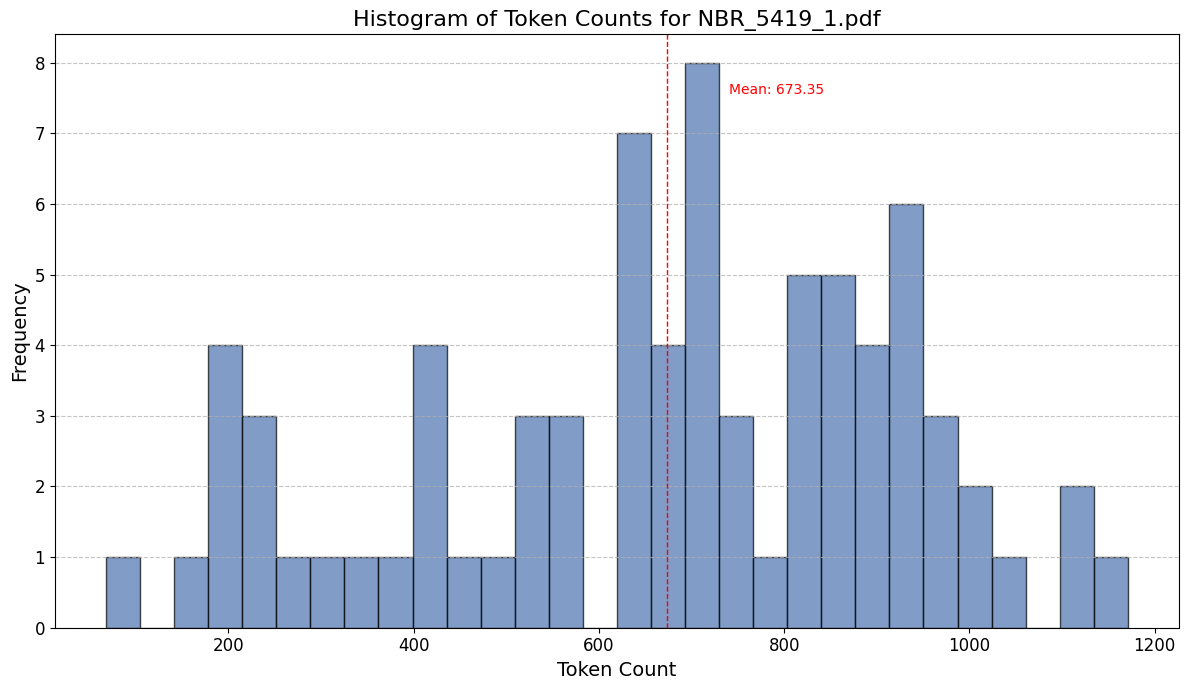

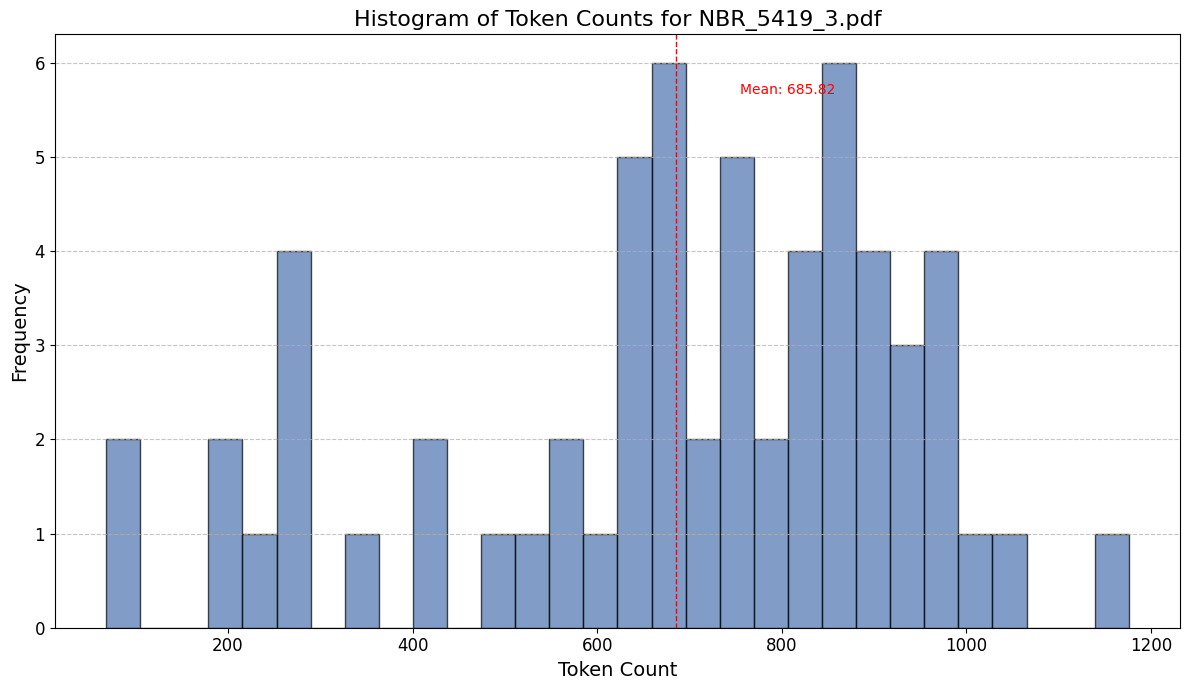

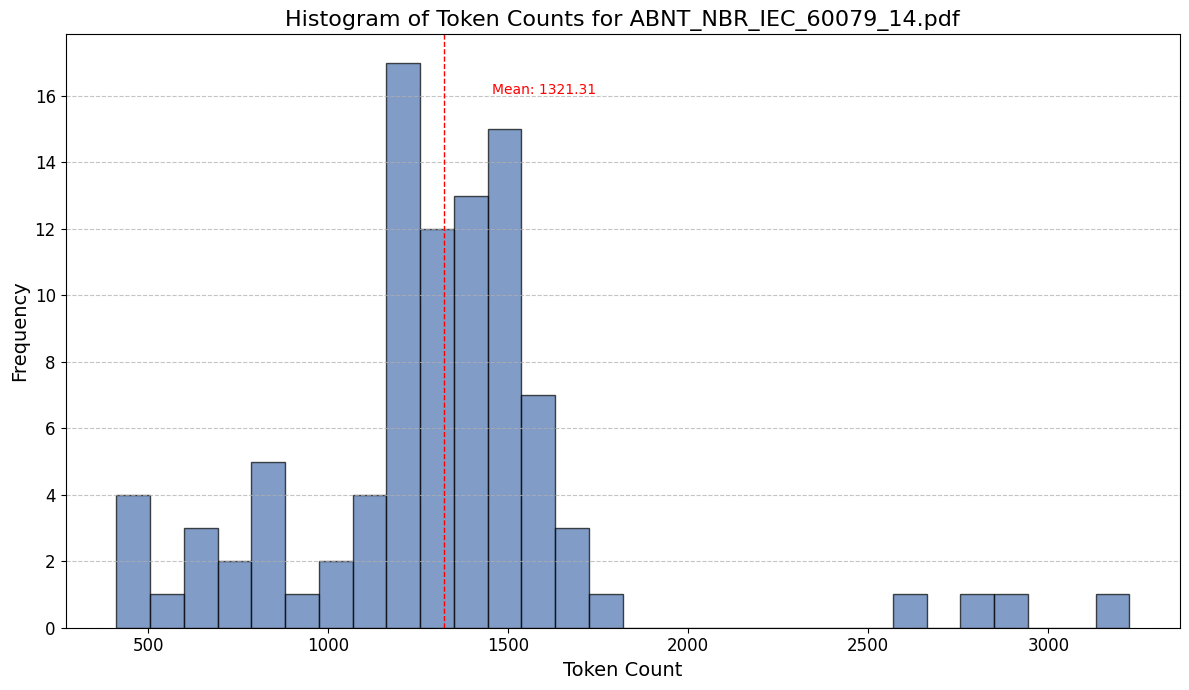

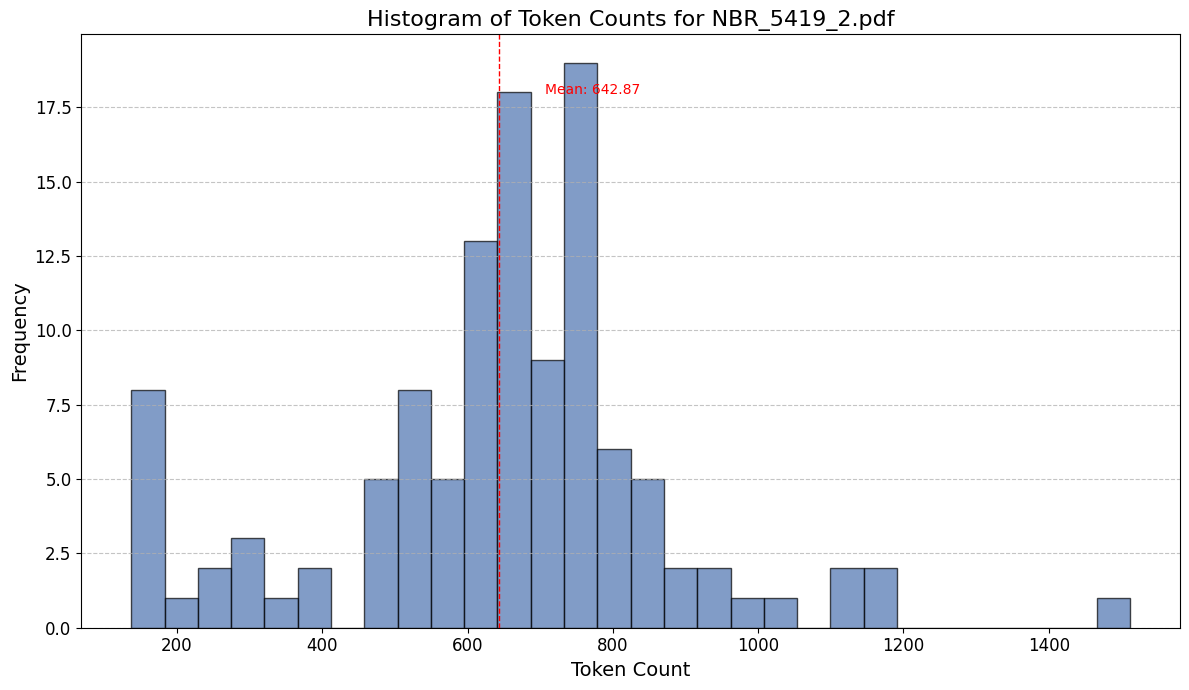

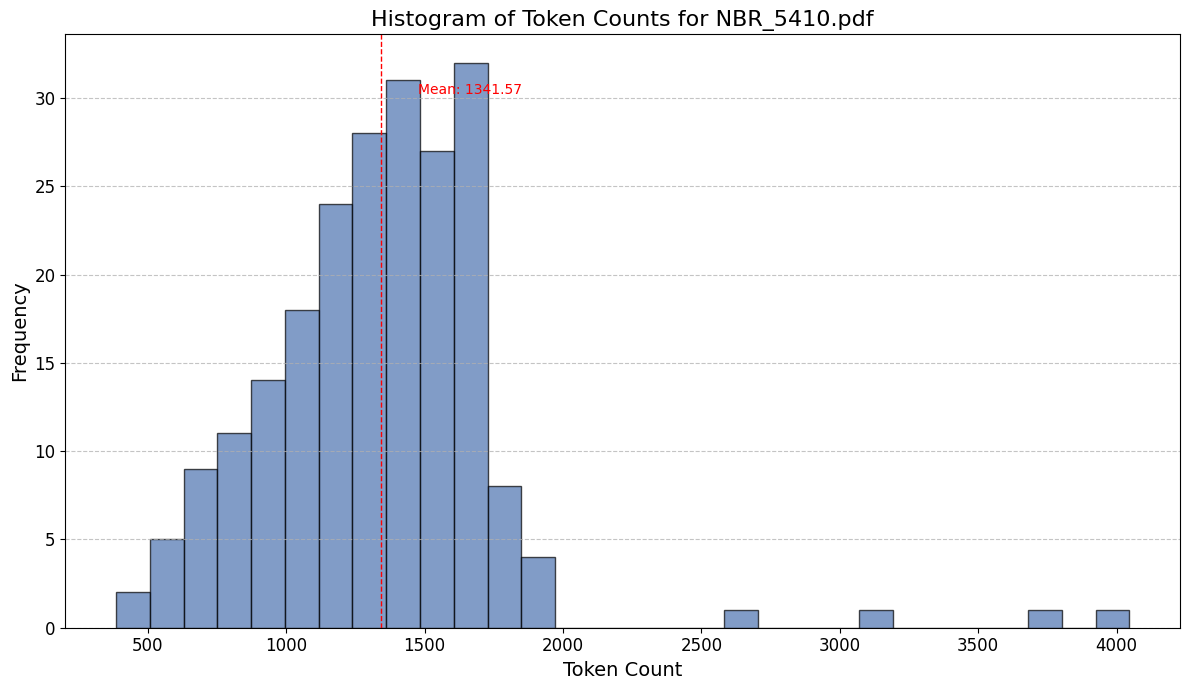

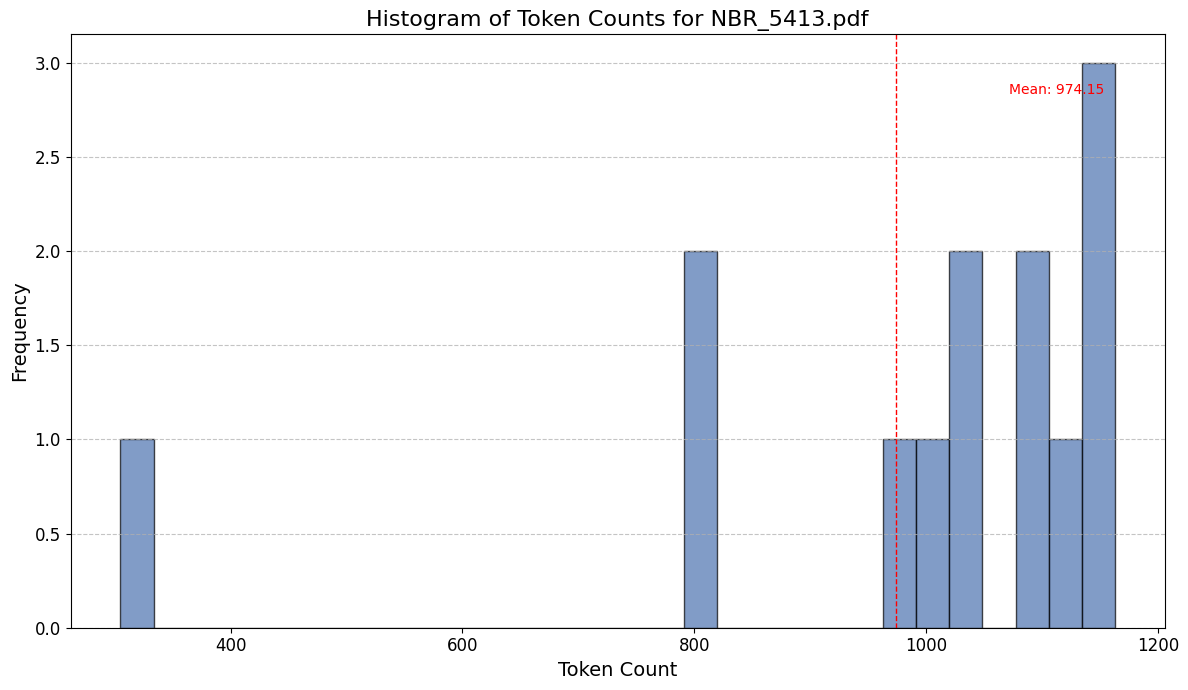

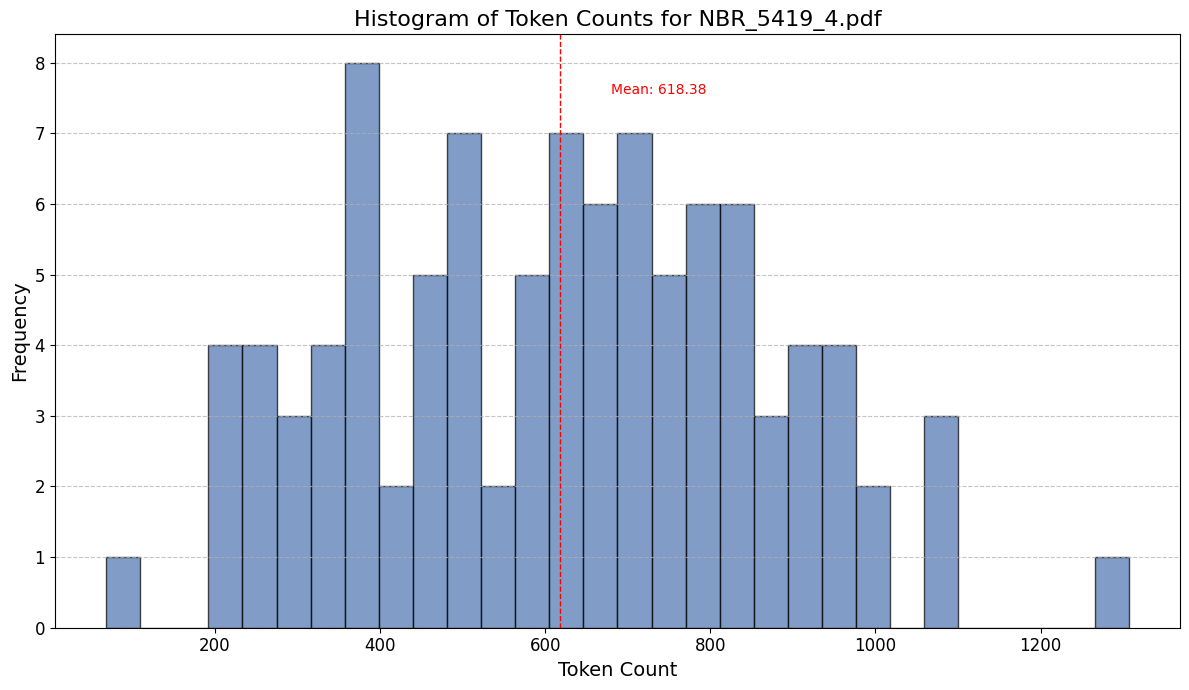

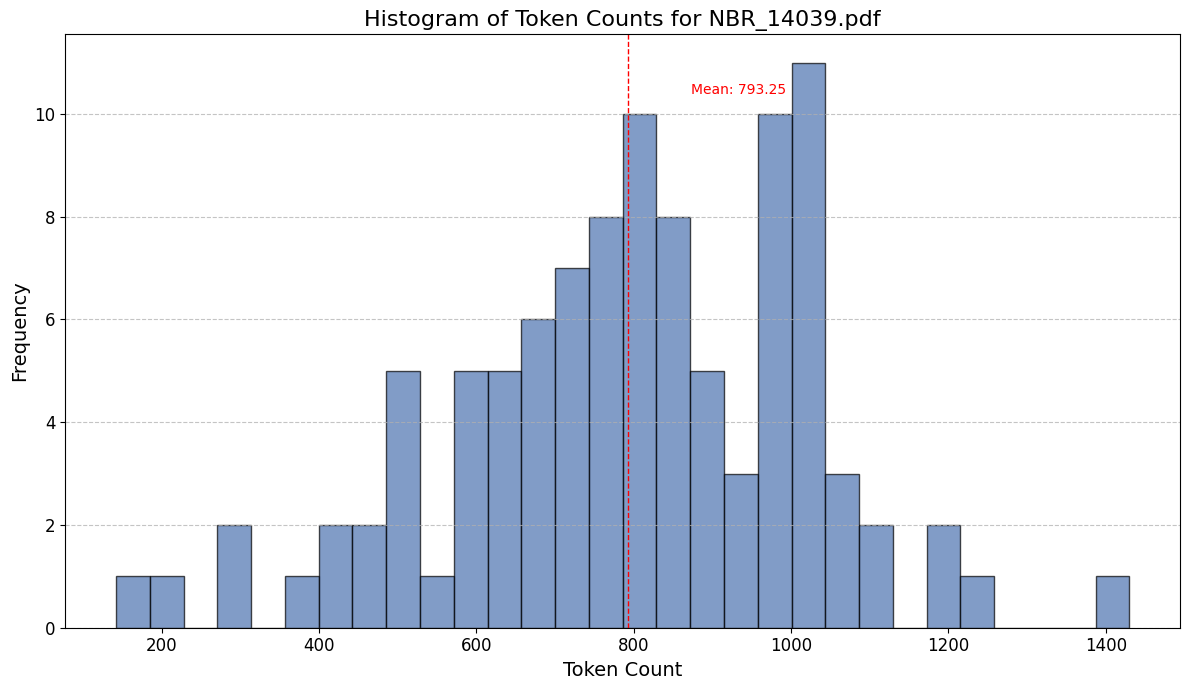

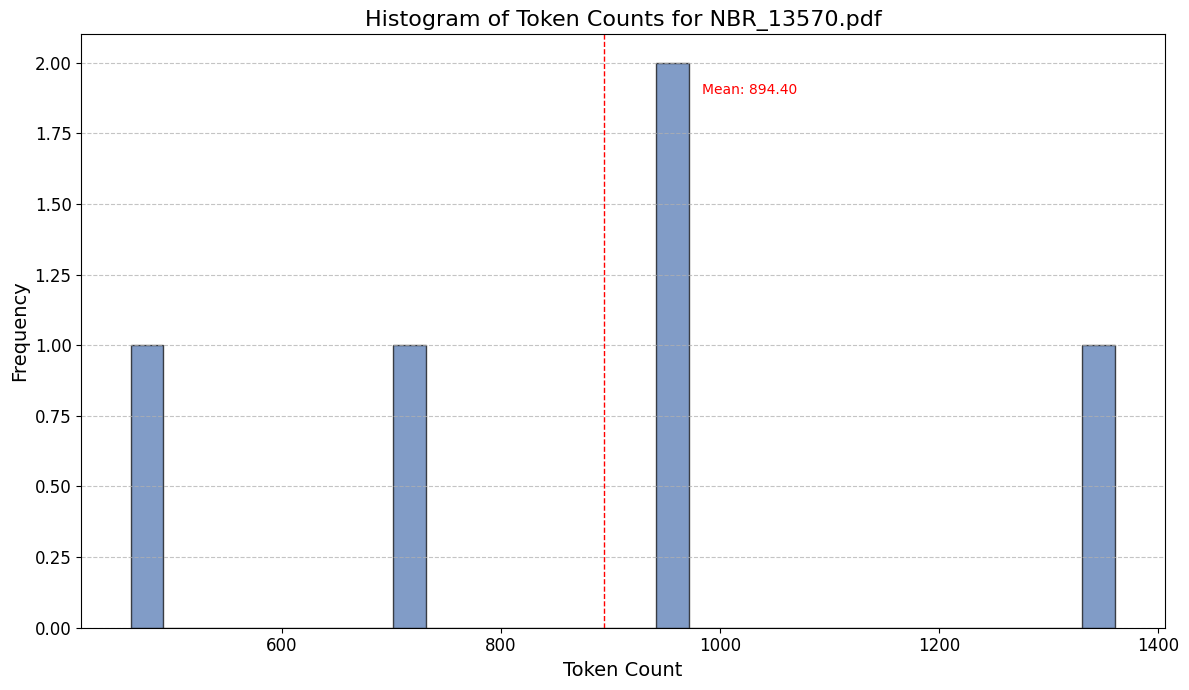

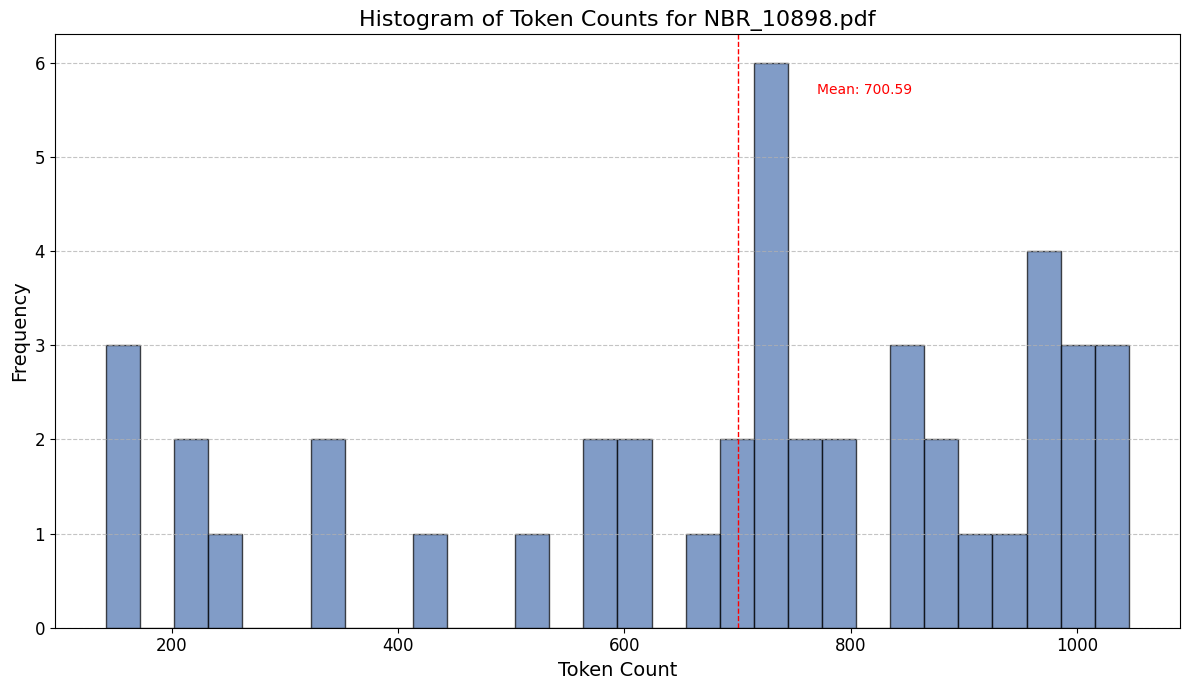

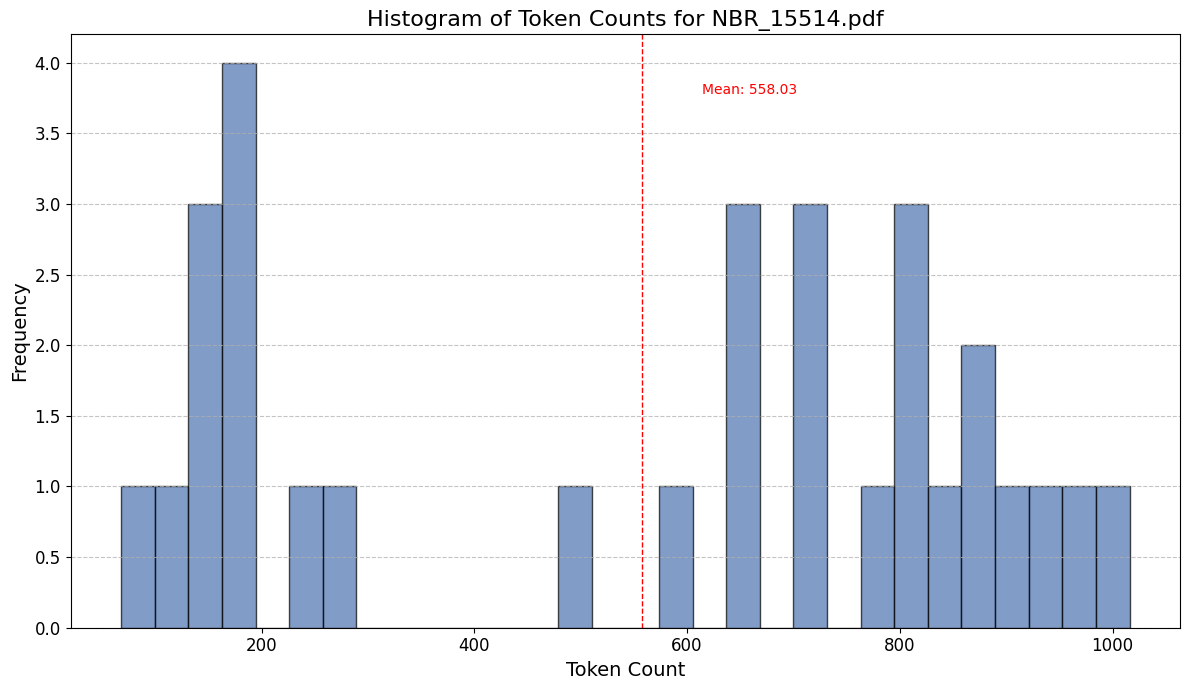

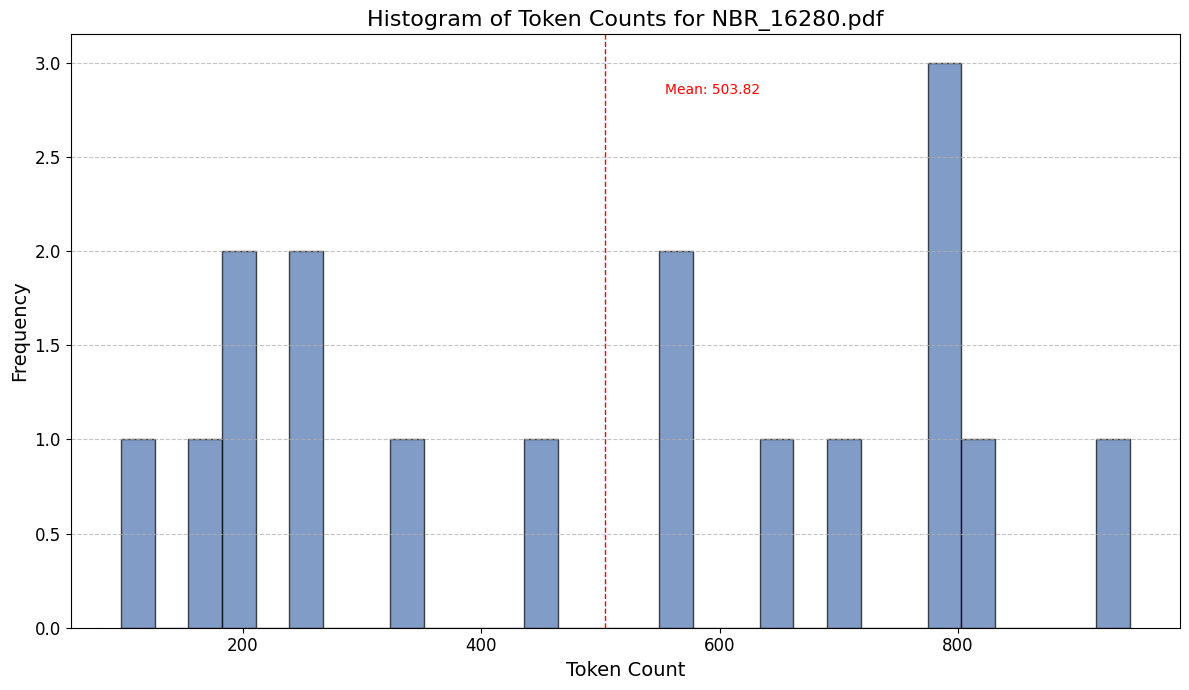

In [7]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Inicializar lista concatenada e lista para plotagem
docs = []
all_counts = []

# Concatenar conteúdo
for filename, docs_in_file in pdf_results.items():
    docs.extend(docs_in_file)
    docs_texts = [d.page_content for d in docs_in_file]

    # Calcular o número de tokens para cada documento
    counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]
    all_counts.extend(counts)

    # Plotar o histograma de contagem de tokens para cada PDF
    plt.figure(figsize=(12, 7))
    plt.hist(counts, bins=30, color="#4C72B0", edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of Token Counts for {filename}", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", alpha=0.75, linestyle='--')
    
    # Melhorar a exibição das legendas
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adicionar uma linha média
    mean_val = sum(counts) / len(counts)
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_val * 1.1, plt.ylim()[1] * 0.9, f'Mean: {mean_val:.2f}', color = 'red')

    # Ajustar layout
    plt.tight_layout()

    # Exibir o histograma
    plt.show()

In [8]:
print(f"Number of total pages in all documents: {len(docs)}")

Number of total pages in all documents: 875


## Text processing

In [9]:
# Ordenar e reverter os documentos
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenar o conteúdo dos documentos
concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_content, "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context before cleaning the documents: {total_tokens}")

Num tokens in all context before cleaning the documents: 800830


### Cleaning the text 

In [10]:
import re

def cleaning_text(text_element: str)-> str:
    
    # Remover quebras de linha desnecessárias
    text = re.sub(r'\n+', ' ', text_element)
    
    # Remover números de página e sequências de dígitos isolados
    text = re.sub(r'\s\d+\s', ' ', text)
    
    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Corrigir espaços antes de pontuação
    text = re.sub(r'\s+([,.;:])', r'\1', text)
    
    return text

In [11]:
# Apply to texts
text = [doc.page_content for doc in d_reversed]

cleaned_texts = [cleaning_text(t) for t in text]

# Concatenar o conteúdo dos documentos
concatenated_cleaned_content  = "\n\n\n --- \n\n\n".join([i for i in cleaned_texts])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_cleaned_content , "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context after cleaning the documents: {total_tokens}")

Num tokens in all context after cleaning the documents: 632619


In [12]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)

texts_split = text_splitter.split_text(concatenated_cleaned_content)
print(f"Number of text splits generated: {len(texts_split)}")

Number of text splits generated: 529


### Embedding text splits

In [15]:
import time

# Função para calcular os embeddings com tempo de espera para evitar rate limit
def generate_embeddings(texts, embd, sleep_time=1):
    """
    Generates embeddings for a list of texts using the provided embedding model.
    
    Returns:
        list: A list of generated embeddings, corresponding to the input texts.
    """
    count = 0
    embeddings = []
    for txt in texts:
        try:
            embedding = embd.embed_query(txt)
            embeddings.append(embedding)
            count+=1
            
        except Exception as e:
            print(f"Error processing {txt[:50]}: {e}")
        
        # Rate-limit processing with sleep 
        if count %100 == 0:
            time.sleep(sleep_time) 
        
    return embeddings

# Gerar os embeddings com tempo de espera de 1 segundo entre as requisições
global_embeddings = generate_embeddings(texts_split, embd, sleep_time=1)

# Exibir o tamanho do vetor para o primeiro chunk
print(f"Size of the vector for the chunk 0 : {len(global_embeddings[0])}")

Size of the vector for the chunk 0 : 768


In [16]:
print(f"Size of the vector for the chunk 2 : {len(global_embeddings[2])}")

Size of the vector for the chunk 2 : 768


In [17]:
len(global_embeddings)

529

In [18]:
type(global_embeddings)

list

## Visualizing the clustering

In [19]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(embeddings: np.ndarray,
                              dim: int,
                              n_neighbors: Optional[int] = None,
                              metric: str = "cosine")-> np.ndarray:
    
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
        
    result =  umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)
    if not isinstance(result, np.ndarray):
        raise TypeError("Unexpected UMAP output type. Expected ndarray.")
    return result

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[ 2.5605779 -3.9782896]


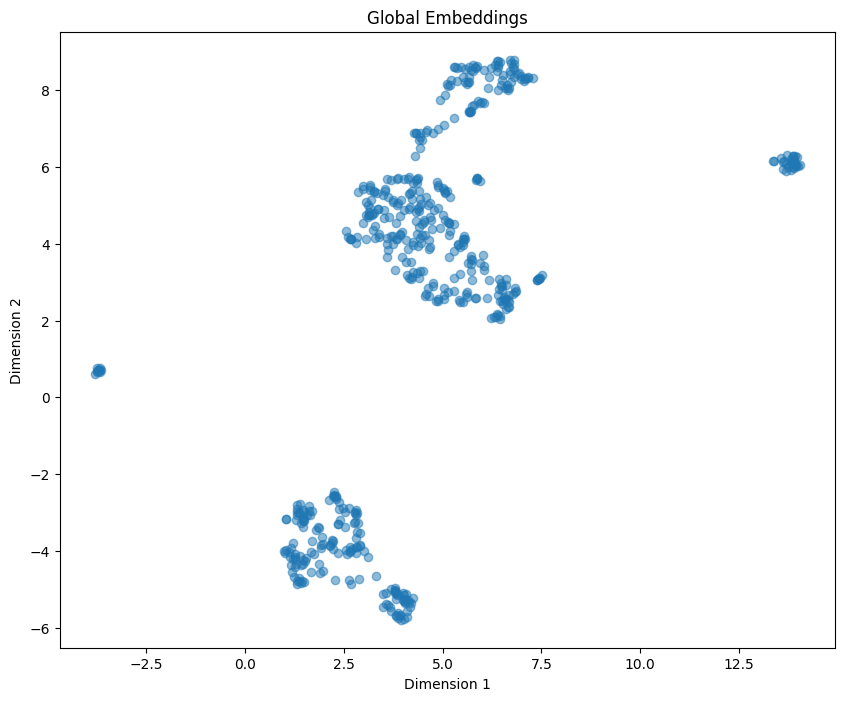

In [20]:
dim = 2

global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

print(global_embeddings_reduced[0])

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [21]:
global_embeddings_reduced

array([[ 2.5605779, -3.9782896],
       [ 2.3970182, -3.2063675],
       [ 2.3484595, -3.3001764],
       ...,
       [ 4.613738 ,  6.959934 ],
       [ 6.697961 ,  8.423038 ],
       [ 7.2805324,  8.324325 ]], dtype=float32)

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 225

def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

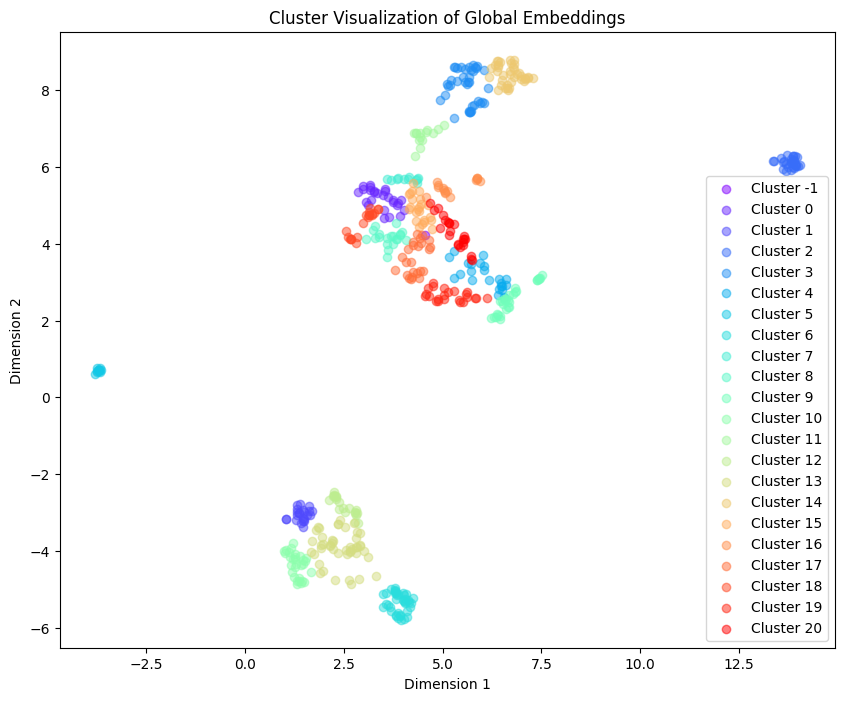

In [23]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [24]:
num_unclassified = np.sum(plot_labels == -1)
print(f"Número de pontos não classificados: {num_unclassified}")

Número de pontos não classificados: 1


In [25]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com um estilo mais legível
display(df.head(10))

,Text,Embedding,Cluster
0,"Bibliografia ABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação ABN...","[2.5605779, -3.9782896]",13
1,Transformado r A T B o b a C T M / TSPDA Subsistema de ate rrament o do edifício atingido pela d...,"[2.3970182, -3.2063675]",13
2,e) os serviços adicionais condutores ligados às instalações. Eles conduzem uma parcela da corren...,"[2.3484595, -3.3001764]",13
3,"Caso estas premissas sejam atendidas, o equipamento está convenientemente protegido pelo DPS 1. ...","[1.9819484, -3.8208857]",13
4,C.2.2 Seleção considerando a localização e a corrente da descarga atmosférica Os DPS devem supor...,"[2.2126744, -3.7893527]",13
5,"C.2.1.4 Quando o DPS é instalado no ponto de entrada da linha na estrutura, um ΔU = kV/m de comp...","[2.1467793, -3.8540328]",13
6,"Valores de probabilidades PDPS como função do NP são dados na ABNT NBR 5419-2:2015, Tabela B.3. ...","[2.22654, -3.7481844]",13
7,Anexo C (informativo) Seleção e instalação de um sistema coordenado de DPS C.1 Introdução Descar...,"[2.1498132, -3.8667383]",13
8,B.15 Visão geral das medidas de proteção possíveis B.15.1 Entrada de energia Redes de alimentaçã...,"[1.2077576, -4.214183]",10
9,B.13.3 Linhas metálicas Sem interconexões apropriadas entre sistemas de aterramento de estrutura...,"[1.0415043, -3.9710402]",10


In [26]:
import pandas as pd

def format_cluster_texts(df: pd.DataFrame) -> pd.DataFrame:
    clustered_texts = []
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts.append({
            'Cluster': cluster,
            'Texts': " --- ".join(cluster_texts)
        })
    return pd.DataFrame(clustered_texts)

# Formatação e visualização dos textos agrupados por cluster
clustered_texts_df = format_cluster_texts(df)

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com os textos agrupados por cluster
display(clustered_texts_df)

,Cluster,Texts
0,13,"Bibliografia ABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação ABN..."
1,10,B.15 Visão geral das medidas de proteção possíveis B.15.1 Entrada de energia Redes de alimentaçã...
2,1,"A medição deve ser realizada com aparelhos que forneçam corrente elétrica entre A e A, com frequ..."
3,6,Anexo F (informativo) Densidade de descargas atmosféricas NG F.1 Considerações sobre os dados ap...
4,12,"falha de um DPS de óxido metálico é relacionada com as suas características mais fracas, sendo, ..."
5,16,12 NBR 5413/1992 - enchimento de fornos:. poço de resíduos.................... - -. aberturas pa...
6,2,2 NBR 5413/1992 5.2.2 O procedimento é o seguinte: a) analisar cada caracter ística para determi...
7,0,ABNT NBR 5410:2004 ABNT NBR 5410:2004 © ABNT  Todos os direitos reservados 209 Anexo M Anexo M ...
8,8,ABNT NBR 5410:2004 ABNT NBR 5410:2004 198 © ABNT  Todos os direitos reservados Anexo G Anexo G ...
9,18,ABNT NBR 5410:2004 ABNT NBR 5410:2004 194 © ABNT  Todos os direitos reservados A figura D.3 mos...


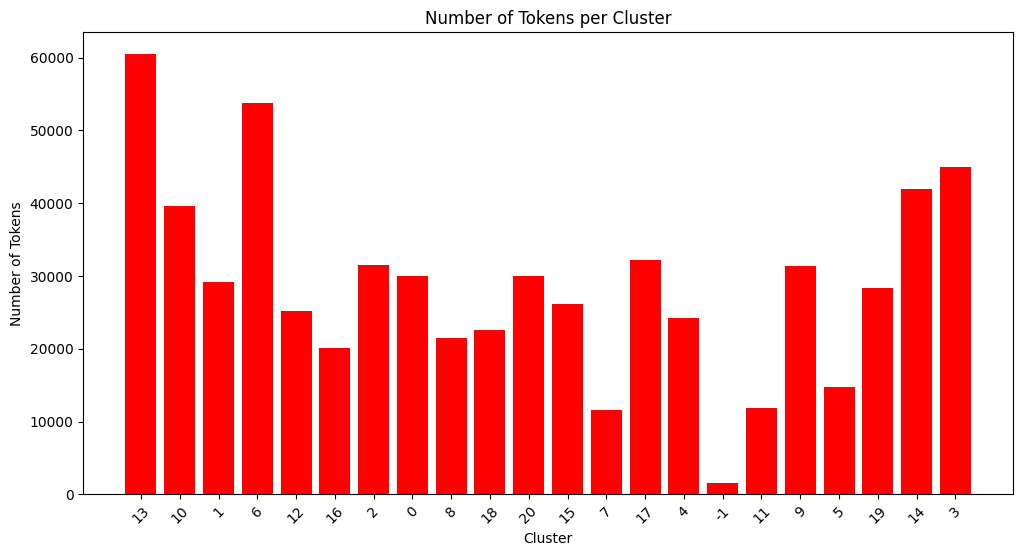

In [27]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

clustered_texts_df['NumTokens'] = clustered_texts_df['Texts'].apply(lambda x: num_tokens_from_string(x, 'cl100k_base'))

# Preparar os dados para o gráfico
cluster_sizes = clustered_texts_df[['Cluster', 'NumTokens']]

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(cluster_sizes['Cluster'].astype(str), cluster_sizes['NumTokens'], color='red')
plt.xlabel('Cluster')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens per Cluster')
plt.xticks(rotation=45)
plt.show()

## Summarizing the clusters - testing!

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")
model = GoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

template = """Você é um assistente para criar um resumo detalhado da entrada de texto fornecida.
Texto:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [ ]:
import time

summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary
    
    print(f"Sleeping for 5 seconds")
    time.sleep(5)

In [ ]:
summaries

In [ ]:
embedded_summaries = [gemini_embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [ ]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [ ]:
clustered_summaries

In [ ]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [ ]:
final_summaries

In [ ]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

## Implementation of the RAPTOR - Recursive Abstractive Processing for Tree-Organized Retrieval

In [50]:
# from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings

embd = OpenAIEmbeddings(model="text-embedding-3-large")
embd

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x2893d89e0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x288a38920>, model='text-embedding-3-large', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [51]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 222  # Fixed seed for reproducibility

### --- Code from citations  --- ###

def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [53]:
# from google.api_core.exceptions import InvalidArgument

def chunk_list(lst, chunk_size):
    """Divide uma lista em partes menores de um tamanho específico."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def embed(texts: List[str], batch_size: int = 100) -> np.ndarray:
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.
    - batch_size: int, maximum number of texts to process in a single batch.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    all_embeddings = []
    for batch in chunk_list(texts, batch_size):
        try:
            batch_embeddings = embd.embed_documents(batch)
            all_embeddings.extend(batch_embeddings)
        except Exception as e:
            raise Exception(f"Error embedding content: {e}")
    return np.array(all_embeddings)




def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Este é um trecho de um conjunto de documentos de normas regulamentadoras brasileiras (NBR's).

    As NBRs (Normas Regulamentadoras Brasileiras) definem padrões, regras e critérios que dizem respeito à aspectos da sociedade brasileira, incluindo práticas de engenharia e arquitetura\
    segurança e saúde no trabalho, qualidade de produtos e serviços, proteção ambiental, padronização de terminologia, desempenho de edificações, rotulagem de produtos, certificação de produtos e serviços.
    

    Faça um resumo detalhado da documentação fornecida.

    Documentação:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

### Build Tree structure

In [47]:
docs_texts = [d.page_content for d in docs]
print(f"Number of pages of all documents: {len(docs_texts)}")

Number of pages of all documents: 875


In [48]:
print(f"Number of pages of all documents cleaned: {len(texts_split)}")

Number of pages of all documents cleaned: 529


In [54]:
# leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(texts_split, level=1, n_levels=4)

--Generated 111 clusters--
--Generated 23 clusters--
--Generated 5 clusters--
--Generated 1 clusters--


### Collapsed Tree Retrieval
* Isso envolve o achatamento da estrutura da árvore em uma única camada e, em seguida, a aplicação de uma pesquisa de k vizinhos mais próximos (kNN) em todos os nós simultaneamente.
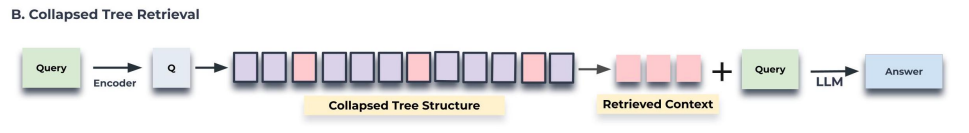

In [55]:
results

{1: (                                                                                                    text                                                                                                 embd  cluster
  0    Bibliografia ABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação ABN...  [-0.005875385832041502, 0.02312365733087063, -0.018269289284944534, 0.02214987762272358, 0.01911...  [102.0]
  1    Transformado r A T B o b a C T M / TSPDA Subsistema de ate rrament o do edifício atingido pela d...  [0.004285136703401804, 0.01962990127503872, -0.01594085991382599, 0.01828025095164776, 0.0054098...  [109.0]
  2    e) os serviços adicionais condutores ligados às instalações. Eles conduzem uma parcela da corren...  [0.003833573078736663, 0.0294233076274395, -0.018461966887116432, 0.04552503675222397, 0.0159424...  [109.0]
  3    Caso estas premissas sejam atendidas, o equipamento está convenientemente protegido pelo DPS 1. ...  [0.020625898614525795

### Add to vectorstore

In [56]:
# Initialize all_texts with leaf_texts
all_texts = texts_split.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

In [67]:
len(all_texts)

669

In [68]:
type(all_texts)

list

In [70]:
all_texts

['Bibliografia ABNT NBR 6323, Galvanização de produtos de aço ou ferro fundido – Especificação ABNT NBR 13571, Haste de aterramento aço-cobreado e acessórios ABNT NBR IEC 60079-10-1, Atmosferas explosivas – Parte 10-1: Classificação de áreas – Atmosferas explosivas de gás ABNT NBR IEC 60079-10-2, Atmosferas explosivas – Parte 10-2: Classificação de áreas – Atmosferas de poeiras combustíveisABNT NBR IEC 60079-14, Atmosferas explosivas – Parte 14: Projeto, seleção e montagem de instalações elétricasIEC 60364-4-44, Low-voltage electrical installations – Part 4-44: Protection for safety – Protection against voltage disturbances and electromagnetic disturbancesIEC 60364-5-53, Electrical installations of buildings – Part 5-53: Selection and erection of electrical equipment – Isolation, switching and controlIEC 61643-11, Low-voltage surge protective devices – Part 11: Surge protective devices connected to low-voltage power systems –Requirements and test methodsIEC (all parts), Protection agai

#### Add the documents to the vectorial database

In [69]:
embd

OpenAIEmbeddings(client=<openai.resources.embeddings.Embeddings object at 0x2893d89e0>, async_client=<openai.resources.embeddings.AsyncEmbeddings object at 0x288a38920>, model='text-embedding-3-large', dimensions=None, deployment='text-embedding-ada-002', openai_api_version='', openai_api_base=None, openai_api_type='', openai_proxy='', embedding_ctx_length=8191, openai_api_key=SecretStr('**********'), openai_organization=None, allowed_special=None, disallowed_special=None, chunk_size=1000, max_retries=2, request_timeout=None, headers=None, tiktoken_enabled=True, tiktoken_model_name=None, show_progress_bar=False, model_kwargs={}, skip_empty=False, default_headers=None, default_query=None, retry_min_seconds=4, retry_max_seconds=20, http_client=None, http_async_client=None, check_embedding_ctx_length=True)

In [73]:
from langchain_community.vectorstores import Chroma

# Diretório onde o vectorstore será persistido
persist_directory = "vectorstore_db"

# Inicializando o vectorstore
vectorstore = Chroma(
    collection_name="RAPTOR_vectorstore",
    embedding_function=embd,
    persist_directory=persist_directory
)

# imprimir banco de dados inicializado
import sqlite3
import pandas as pd

# Conexão ao banco de dados SQLite
conn = sqlite3.connect('vectorstore_db/chroma.sqlite3')

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
# Consulta SQL
query = "SELECT * FROM embedding_fulltext_search"

# Executa a consulta e retorna um DataFrame
df = pd.read_sql_query(query, conn)

print(tables)
# Exibe o DataFrame
print(df,"\n\n")

conn.close()

Empty DataFrame
Columns: [string_value]
Index: [] 


                                 name
0                          migrations
1                    embeddings_queue
2                 collection_metadata
3                            segments
4                    segment_metadata
5                             tenants
6                           databases
7                         collections
8                          embeddings
9                  embedding_metadata
10                         max_seq_id
11          embedding_fulltext_search
12     embedding_fulltext_search_data
13      embedding_fulltext_search_idx
14  embedding_fulltext_search_content
15  embedding_fulltext_search_docsize
16   embedding_fulltext_search_config


In [74]:
vectorstore.add_texts(all_texts)

['3011cc49-d7b2-4e76-8c33-235da66193dc',
 '6174fd15-1b24-4032-be2b-90844128693f',
 'f9b04c05-16b7-44e2-a430-99fb6f0068ff',
 'e9b851de-3dcf-4db9-90ac-69834cd9b721',
 '6d4122dc-ea7f-45ae-8e02-b73d2767f463',
 'db339ffe-f8e9-4ea3-92ab-58cf39872e95',
 'bcda0347-34fb-4027-8eb6-ba5ab144e2d8',
 'e18e4b7c-094b-4a43-97a4-d27123504626',
 '2b9f8e7d-766d-4003-83de-7780bf10bcdb',
 'a83bee81-c829-494c-a406-2622dd9e29bf',
 '0b74bc4c-7418-4d03-a2c4-c7acdc54ef49',
 '36a925d4-6f07-4e50-86db-b9c0ef45c05a',
 'edd3822f-7603-46e1-b005-3267d37a4e15',
 'e296ed0a-6f66-4f46-b35b-b98100fe6b81',
 '634a82d0-b6f2-4c03-8f2b-43ea455da055',
 'd7f20cda-ef6d-4f61-82d0-63618f706254',
 '1822b33a-606f-4267-96e5-df34aa641307',
 'b1052535-a35d-43dc-b14c-37b7684b1f15',
 '31731a3c-bad8-4540-80e1-93396e883de9',
 'dd969ffe-af63-4de9-84c6-8a974232a192',
 'fd277409-169b-453b-ad0b-13faccebdd33',
 'b6518e82-f193-4632-88c2-e70bc674eb89',
 'f4741a21-fbfe-4645-9176-a5ab03fd1df1',
 '6dba1147-b4df-4376-8942-071cf11a1d4b',
 'ed1cedcc-7819-

In [80]:
# Conexão ao banco de dados SQLite
conn = sqlite3.connect('vectorstore_db/chroma.sqlite3')

# Executa a consulta e retorna um DataFrame
df = pd.read_sql_query("SELECT * FROM collections", conn)

# Exibe o DataFrame
print(df,"\n\n")

                                     id                name  dimension                           database_id
0  0fef69af-e7c2-4ccd-b795-f28ea7e0faec  RAPTOR_vectorstore       3072  00000000-0000-0000-0000-000000000000 




In [75]:
#define retriver
retriever = vectorstore.as_retriever()

## RAG Pipeline

In [85]:
import textwrap
from IPython.display import Markdown

def to_markdown(text):
    text = text.replace('•', '*')
    text = textwrap.dedent(text).strip()

    return Markdown(text)

In [76]:
from langchain_core.runnables import RunnablePassthrough

template = """
Responda a pergunta baseado no seguinte contexto:
{context}

Responda a seguinte pergunta.:
Pergunta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [79]:
# Question
response = rag_chain.invoke("O que diz a norma NBR 5410 no geral?")
to_markdown(response)

A norma brasileira **NBR 5410:2004** estabelece as diretrizes e requisitos para **instalações elétricas de baixa tensão**, visando garantir a segurança de pessoas e animais, o funcionamento adequado da instalação e a preservação de bens. 

Em outras palavras, ela define como as instalações elétricas de baixa tensão (até 1000V em corrente alternada ou 1500V em corrente contínua) devem ser projetadas, instaladas e mantidas para garantir a segurança de todos.

A norma abrange diversos aspectos, como:

* **Proteção contra choques elétricos:** Define medidas de proteção para evitar contato com partes energizadas e garantir a segurança em caso de falhas.
* **Proteção contra sobrecorrentes e curto-circuito:**  Exige a instalação de dispositivos de proteção para evitar danos à instalação e riscos de incêndio.
* **Dimensionamento de condutores:**  Determina a bitola adequada dos fios e cabos elétricos para suportar a corrente elétrica sem superaquecimento.
* **Divisão da instalação:**  Recomenda a divisão da instalação em circuitos para garantir segurança, funcionalidade e facilitar a manutenção.
* **Seleção de materiais e equipamentos:**  Especifica os requisitos para os materiais e equipamentos utilizados, garantindo a qualidade e a compatibilidade.
* **Inspeção e manutenção:**  Destaca a importância da inspeção e manutenção periódica para garantir o funcionamento seguro da instalação ao longo do tempo.

A NBR 5410:2004 é uma norma fundamental para garantir a segurança em instalações elétricas de baixa tensão, sendo sua aplicação essencial em projetos, construções, reformas e manutenções.

In [84]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain.invoke(question)
to_markdown(response)

A ABNT NBR IEC 60079-14:2009 não se trata de uma Norma Regulamentadora (NR), mas sim de uma norma técnica brasileira baseada na norma internacional IEC 60079-14. Ela trata especificamente de instalações elétricas em áreas classificadas, enquanto a NR 10 (Segurança em Instalações e Serviços em Eletricidade) tem um escopo mais amplo. 

**A NR 10 não detalha requisitos específicos para áreas classificadas como a ABNT NBR IEC 60079-14:2009 o faz.** 

Entretanto, a NR 10 exige, em seu item 10.8.1, que os trabalhos em áreas classificadas sigam também normas técnicas oficiais estabelecidas pelos órgãos competentes. Isso significa que a **ABNT NBR IEC 60079-14:2009, junto com outras normas aplicáveis, como a NR 10, deve ser seguida em áreas classificadas.**

Em resumo:

* **NR 10:** requisitos gerais de segurança em instalações elétricas.
* **ABNT NBR IEC 60079-14:2009:** requisitos específicos para instalações elétricas em áreas classificadas.

Ambas as normas devem ser consideradas para garantir a segurança em instalações elétricas em áreas classificadas. Adicionalmente, outras normas podem ser aplicáveis dependendo das características específicas da área classificada.

In [95]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.runnables import RunnableMap


template = """
Responda a pergunta baseado no seguinte contexto:
{context}

Responda a seguinte pergunta.:
Pergunta: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Função para imprimir o contexto
def print_context(context):
    print("Contexto fornecido:", context)
    return context

rag_chain_with_context = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | RunnableMap({"context": print_context, "question": RunnablePassthrough()})
    | prompt
    | model
    | StrOutputParser()
)

In [96]:
# Question
question = "Quais são as exigências da Norma Regulamentadora NR 10 para as instalações elétricas em áreas classificadas?"
response = rag_chain_with_context.invoke(question)
to_markdown(response)

Contexto fornecido: {'context': "ABNT NBR IEC 60079-14:2009 ABNT NBR IEC 60079-14:2009 24 © IEC - © ABNT - Todos os direitos reservados 6.2.5 6.2.5 Separação Separação elétrica elétrica A se paração elétrica deve estar de acordo com a Seção da I EC 60364-4-41 para a alimentaçã o d e somente um item do equipamento. 6.2.6 6.2.6 Equipamentos Equipamentos acima acima de de áreas áreas classificadas classificadas Equipamentos que podem produzir partículas aquecidas ou superfícies quentes localizados a menos que 3,5 m acima de áreas classificadas devem ser totalmente fechados ou fornecidos com proteções ou telas adequadas, para evitar quaisquer fontes de ignição caindo para o interior da área classificada. NOTA Tais itens podem incluir: \ue000 fusíveis que possam produzir arcos, centelhas ou partículas aquecidas; \ue000 dispositivos que possam produzir arcos, centelhas ou partículas aquecidas; \ue000 motores ou geradores que possuam contatos deslizantes ou escovas; \ue000 aquecedores, elemen

O texto fornecido refere-se à norma **ABNT NBR IEC 60079-14:2009**, que trata especificamente de instalações elétricas em áreas classificadas. A pergunta, no entanto, é sobre as exigências da **Norma Regulamentadora NR 10**. 

Embora ambas as normas tratem de segurança em instalações elétricas, elas possuem escopos diferentes. A **NR 10** é uma norma nacional que aborda a segurança em instalações e serviços em eletricidade de forma geral, enquanto a **ABNT NBR IEC 60079-14:2009** é uma norma técnica que detalha especificamente as instalações em áreas com risco de explosão.

Para responder à pergunta sobre as exigências da **NR 10** em áreas classificadas, seria necessário consultar a própria norma e seus anexos. De forma geral, a **NR 10** exige que os procedimentos de segurança em áreas classificadas sejam elaborados e implementados por profissional autorizado, considerando as características específicas da área e os riscos adicionais presentes. 

**A NR 10 aborda, entre outros aspectos:**

* **Medidas de controle dos riscos:**  incluindo a desenergização, aterramento, medidas contra choques elétricos, sinalização, etc., que devem ser aplicadas de forma ainda mais rigorosa em áreas classificadas.
* **Treinamento específico:** os trabalhadores que atuam em áreas classificadas devem receber treinamento específico sobre os riscos elétricos e as medidas de segurança adicionais.
* **Uso de equipamentos e ferramentas adequadas:** os equipamentos e ferramentas utilizados em áreas classificadas devem ser certificados para uso em atmosferas explosivas.
* **Documentação:** as empresas devem manter documentação atualizada sobre a classificação da área, os procedimentos de segurança, o treinamento dos trabalhadores e as características dos equipamentos instalados.

**Em resumo:** a resposta à sua pergunta não está presente no texto fornecido. Para obter informações completas sobre as exigências da NR 10 em áreas classificadas, consulte a norma e seus anexos.

In [97]:
# Question
question = 'O que diz a norma NBR 5410 no geral?'
response = rag_chain_with_context.invoke(question)
to_markdown(response)

Contexto fornecido: {'context': 'O trecho fornecido apresenta parte da norma brasileira **ABNT NBR 5410:2004**, que trata de instalações elétricas de baixa tensão. Apesar de fragmentado, o documento permite extrair informações relevantes sobre:\n\n**1. Escopo da NBR 5410:**\n\nA norma define critérios e procedimentos para garantir a segurança de instalações elétricas de baixa tensão, incluindo:\n\n* **Seleção e instalação de linhas elétricas:** Considerando uma série de fatores como temperatura ambiente, umidade, presença de poeira, riscos de incêndio, entre outros.\n* **Dimensionamento de condutores:** Determinando a capacidade de condução de corrente dos condutores em função das condições de instalação e da temperatura ambiente.\n* **Proteção contra choques elétricos:** Estabelecendo medidas de proteção para garantir a segurança das pessoas contra contatos diretos e indiretos com partes energizadas.\n* **Proteção contra sobrecorrentes e curto-circuito:** Definindo dispositivos de pro

A norma NBR 5410:2004 define os critérios e procedimentos para garantir a segurança de instalações elétricas de baixa tensão, com foco em proteger pessoas e animais, assegurar o bom funcionamento da instalação e a preservação de bens. 

Em linhas gerais, a norma aborda:

* **Segurança:** Define medidas de proteção contra choques elétricos (proteção básica e supletiva), curtos-circuitos e sobrecargas, especialmente em áreas com risco de incêndio ou explosão.
* **Dimensionamento:**  Estabelece diretrizes para determinar a potência de alimentação, prever a carga de cada circuito e dimensionar condutores, considerando fatores como temperatura ambiente e tipo de instalação.
* **Divisão da instalação:** Exige a divisão da instalação em circuitos para garantir segurança, funcionalidade e facilitar a manutenção.
* **Especificações técnicas:** Define os requisitos para seleção e instalação de componentes como tomadas, dispositivos de proteção, fiação e linhas elétricas.
* **Documentação:**  Exige a elaboração de projetos, relatórios e outros documentos técnicos para garantir a conformidade com a norma.

A NBR 5410:2004 se aplica a instalações novas e reformas em edificações residenciais, comerciais, industriais e áreas externas, incluindo trailers, acampamentos e canteiros de obras. A norma não se aplica a instalações de tração elétrica, veículos, aeronaves e proteção contra raios, que possuem normas específicas.

É fundamental consultar a íntegra da norma para a correta interpretação e aplicação de seus requisitos, garantindo a segurança e eficiência das instalações elétricas.

## Black Box End-to-End Evaluation

In [ ]:
len(all_texts)

In [90]:
import uuid 

id_key = "doc_id"
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in all_texts]
page_content_all_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(all_texts)
]
print(len(page_content_all_texts))

669


In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

# documents = load your documents

# generator with openai models
generator_llm = ChatOpenAI(model="gpt-3.5-turbo-16k")
critic_llm = ChatOpenAI(model="gpt-4")
embeddings = OpenAIEmbeddings()

generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

# Change resulting question type distribution
distributions = {
    simple: 0.5,
    multi_context: 0.4,
    reasoning: 0.1
}

testset = generator.generate_with_langchain_docs(page_content_all_texts, 10, distributions) 
testset.to_pandas()